### Token mask label level

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import csv
import torch
import torchvision.transforms as T

import csv
import torchvision.transforms.functional as TF


import pickle

data = "generated"


def preprocess(img, target_image_size=256):
    s = min(img.size)
    if s < target_image_size:
        raise ValueError(f'Min dimension for image {s} < {target_image_size}')
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img


def load_top_tokens_baseline(input_csv, top_n):
    # 存储Token和Count的列表
    tokens = []
    
    # 读取CSV文件
    with open(input_csv, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            token = int(row['Token'])  # 读取Token
            count = int(row['Count'])  # 读取Count
            tokens.append((token, count))  # 将Token和Count存入列表
    
    # 按照Count降序排序
    tokens.sort(key=lambda x: x[1], reverse=True)
    
    # 获取前N个Token
    top_n_tokens = [token for token, _ in tokens[:top_n]]
    
    return top_n_tokens

def load_top_tokens(csv_path, top_n, token_number):
    target_token_list = []
    """
    从指定的csv文件中加载Top N的某一行token及其对应的文件列表。

    参数:
    csv_path (str): 要读取的csv文件路径。
    top_n (int): 要查询的Top N级别（如1, 5, 10, 20）。
    row_num (int): 要查询的行号（从1开始，排除表头）。

    返回:
    token (str): 对应的token索引。
    files (list): 对应的文件列表。
    """
    with open(csv_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        in_top_n_section = False
        current_row = 0

        for row in reader:
            # 检查是否到了Top N的部分
            if f"Top {top_n} Tokens" in row:
                in_top_n_section = True
                next(reader)
                current_row = 0
                continue

            # 如果到了Top N部分，开始读取指定行
            if in_top_n_section:
                if "Top" in row[0] or current_row == token_number:
                    break
                token = int(row[0])  # 获取token索引
                files = row[2].split('; ')  # 获取文件名列表，并按分号分割
                target_token_list.append(token)
                current_row += 1

    return target_token_list  # 如果未找到，则返回None


# 提供要查找的特定 token
target_label = 83  # 替换为你要查找的token索引

# # 提供要处理的npy文件名列表

if data == "generated":
    csv_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/results/Explanation/generated_data/label/Net1/label_activation_statistics/label_{target_label}.csv"
    test_csv = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated_new/test_embeddings.csv"
    image_base_path = '/data2/ty45972_data2/taming-transformers/datasets/imagenet_VQGAN_generated/'
    baseline_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/results/Explanation/baseline_statistics/label_{target_label}.csv"
    with open('/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated_new/test_token_indices.pkl', 'rb') as f:
        token_dict = pickle.load(f)

# elif data == "original":
#     csv_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/results/Explanation/original_data/label/Net1/label_activation_statistics/label_{target_label}.csv"
#     activation_results_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/results/Explanation/original_data/label/Net1/label_activation_results/label_{target_label}.csv"
#     image_base_path = "/data2/ty45972_data2/taming-transformers/datasets/imagenet/train"
#     with open('/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_original/train_token_indices.pkl', 'rb') as f:
#         token_dict = pickle.load(f)

top_n = 20  # 表示查找Top n Tokens
token_num = 50  # 查找第1行的token及其文件列表


target_token_list = load_top_tokens(csv_path, top_n, token_num)
target_token_list_baseline = load_top_tokens_baseline(baseline_path, token_num)
print(f"baseline token list is {target_token_list_baseline}")

if target_token_list:
    print(f"target token list is {len(target_token_list)}")
else:
    print("Cannot find the specific token")

npy_file_list = []
with open(test_csv, 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # 跳过表头
    
    # 遍历CSV文件的每一行
    for row in reader:
        filename = row[0]  # 获取filename列（第1列）
        label = int(row[1])     # 获取label列（第2列）
        
        # 如果label是指定的label，则将filename添加到列表中
        if label == target_label:
            npy_file_list.append(filename)
print(f"npy_file_list is {len(npy_file_list)}")
# 定义每个图像的token网格大小，假设为16x16
grid_size = 16
image_size = 256
patch_size = image_size // grid_size

def visualize_token_on_image(npy_filename, token_dict, target_token_list):
    # 提取子文件夹和图片名信息
    subfolder, image_name = npy_filename.split('_')
    image_name = image_name.replace('.npy', '.png')
    
    # 构建图像路径
    if data == "generated":
        image_path = os.path.join(image_base_path, subfolder, image_name)
    elif data == "original":
        image_path = os.path.join(image_base_path, subfolder, npy_filename.replace(".npy", ".JPEG"))
    
    print(f"Image path is {image_path}")
    # 检查文件是否存在
    if not os.path.exists(image_path):
        print(f"Image {image_path} does not exist.")
        return
    
    # 打开图像
    image = Image.open(image_path)
    if data == "original":
        processed_img = preprocess(image)
        processed_img_pil = Image.fromarray((processed_img.squeeze(0).permute(1, 2, 0).numpy() * 255).astype(np.uint8))
        image = processed_img_pil
    
    # 获取该文件对应的 token 列表
    token_list = token_dict.get(npy_filename)
    
    if token_list is None:
        print(f"No token list found for {npy_filename}.")
        return
    
    # 查找目标 token 的所有索引位置
    token_positions = [i for i, token in enumerate(token_list) if token in target_token_list]

    

    # 在图像上mask掉每个目标token的位置
    draw = ImageDraw.Draw(image)
    for token_position in token_positions:
        row = token_position // grid_size
        col = token_position % grid_size
        
        # 计算token在原图中的坐标
        left = col * patch_size
        upper = row * patch_size
        right = left + patch_size
        lower = upper + patch_size
        
        # 用黑色填充这些区域，表示mask
        draw.rectangle([left, upper, right, lower], fill=(0, 0, 0))
    
    # 可视化图像
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"token list")
    plt.axis('off')
    plt.show()

# 遍历所有 npy 文件，进行可视化

for i, npy_file in enumerate(npy_file_list):
    visualize_token_on_image(npy_file, token_dict, target_token_list_baseline)
    if i > 10:
        break


### Save Token indice pkl

In [ ]:
import pickle
from tqdm import tqdm
import ast

def load_token_indices(embedding_csv_path):
    # 生成保存token indices的文件名
    token_indices_save_path = embedding_csv_path.replace("test_embeddings.csv", "test_token_indices.pkl")
    
    # 检查是否已经存在保存的token_indices文件
    if os.path.exists(token_indices_save_path):
        print(f"Loading token indices from {token_indices_save_path}")
        with open(token_indices_save_path, 'rb') as f:
            token_indices_dict = pickle.load(f)
        return token_indices_dict
    
    # 如果没有保存的token_indices文件，就进行处理
    print(f"Processing token indices from {embedding_csv_path}")
    token_indices_dict = {}

    # 先计算文件中的总行数，以便显示进度条
    with open(embedding_csv_path, 'r') as infile:
        total_lines = sum(1 for _ in infile) - 1  # 减去header行

    # 重新打开文件并读取内容，同时显示进度条
    with open(embedding_csv_path, 'r') as infile:
        reader = csv.reader(infile)
        next(reader)  # 跳过header
        for row in tqdm(reader, total=total_lines, desc="Loading token indices"):
            npy_file = row[0]
            token_indices = ast.literal_eval(row[2])
            token_indices_dict[npy_file] = token_indices
    
    # 保存处理后的token_indices_dict
    with open(token_indices_save_path, 'wb') as f:
        pickle.dump(token_indices_dict, f)
    print(f"Token indices saved to {token_indices_save_path}")
    
    return token_indices_dict

embedding_csv_path = "/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated_new/test_embeddings.csv"
token_indices_dict = load_token_indices(embedding_csv_path)

#### Optimization Visualization and logits difference

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import argparse
from tqdm import tqdm
import os
import sys
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(parent_directory)
from model import ClassificationNet1, ClassificationNet2, ClassificationNet3

parent_directory = os.path.abspath(os.path.join(current_directory, '../..'))
sys.path.append(parent_directory)

from omegaconf import OmegaConf
from main import instantiate_from_config
from datetime import datetime
from einops import rearrange
from taming.models.new_vqgan import VQModel, GumbelVQ

rescale = lambda x: (x + 1.) / 2.
target_label = 16 # Example label
initial_label = 13  # Example original label

# Convert CHW tensor to a PIL image
def chw_to_pillow(x):
    return Image.fromarray((255*rescale(x.detach().cpu().numpy().transpose(1,2,0))).clip(0,255).astype(np.uint8))

# Load classification model
def load_classification_model(model_choice, model_path, device):
    num_classes = 1000  # 假设有1000个类别，可以根据实际情况调整
    if model_choice == 1:
        model = ClassificationNet1(num_classes)
    elif model_choice == 2:
        model = ClassificationNet2(num_classes)
    elif model_choice == 3:
        model = ClassificationNet3(num_classes)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Load pretrained model (ResNet50 or ViT)
def load_pretrained_model(model_name, device):
    if model_name == 'resnet50':
        model = torchvision.models.resnet50(pretrained=True)
    elif model_name == 'vit_b_16':
        model = torchvision.models.vit_b_16(pretrained=True)
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    model.to(device)
    model.eval()
    return model

# Preprocess image for pretrained models
def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return preprocess(image).unsqueeze(0)

# Generate maximum activation image with partial optimization
def generate_max_activation_image(model, target_label, device, input_shape=(1, 256, 16, 16), lr=0.1, num_steps=10000, reg=0, VQ_model=None, mask=None, initial_embedding=None, save_path=None, pretrained_model=None):
    input_embedding = initial_embedding.clone().detach().requires_grad_(True).to(device)
    
    if mask is not None:
        mask = mask.to(device)

    optimizer = torch.optim.Adam([input_embedding], lr=lr)
    
    for step in tqdm(range(num_steps), desc="Optimizing image"):
        optimizer.zero_grad()
        
        output = model(input_embedding)
        loss = -output[0, target_label] + reg * torch.mean(input_embedding ** 2)
        
        loss.backward()
        
        if mask is not None:
            input_embedding.grad *= mask
        
        optimizer.step()
        
        if step == 0 or step == 100 or step == 200 or step == 500 or step == 1000 or step == 2000 or step == 5000:
            print(f"Step {step}, Loss: {loss.item()}")
            _, _, token_feature_maps, _ = decode_input_embedding(input_embedding, VQ_model)
            for i, token_feature_map in enumerate(token_feature_maps):
                token_feature_map_img = chw_to_pillow(token_feature_map)
                
                # Evaluate with pretrained model
                if pretrained_model:
                    preprocessed_img = preprocess_image(token_feature_map_img).to(device)
                    with torch.no_grad():
                        pretrained_output = pretrained_model(preprocessed_img)
                    original_logit = pretrained_output[0, initial_label].item()
                    target_logit = pretrained_output[0, target_label].item()
                    print(f"Pretrained model - Original label logit: {original_logit}, Target label logit: {target_logit}")
                
                plt.imshow(token_feature_map_img)
                plt.title(f"Step {step} Token Feature Map")
                save_image(token_feature_map_img, save_path, step)
                plt.show()

    return input_embedding

def save_image(image, save_path, step):
    image_file = os.path.join(save_path, f"{step}.png")
    image.save(image_file)

def load_model(config_path, checkpoint_path, device=None, eval_mode=True):
    config = OmegaConf.load(config_path)
    model = instantiate_from_config(config.model)
    
    if checkpoint_path and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location="cpu")
        if "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"])
        else:
            raise ValueError("Checkpoint does not contain state_dict.")
    else:
        raise ValueError(f"Checkpoint file {checkpoint_path} not found.")
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    
    if eval_mode:
        model.eval()
    
    return model

def load_config(config_path):
    return OmegaConf.load(config_path)

# Decode input embedding using VQGAN
def decode_input_embedding(input_embedding, VQ_model):
    codebook = VQ_model.quantize.embedding

    z = rearrange(input_embedding, 'b c h w -> b h w c').contiguous()
    z_flattened = z.view(-1, 256)

    d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
        torch.sum(codebook.weight**2, dim=1) - 2 * \
        torch.einsum('bd,dn->bn', z_flattened, rearrange(codebook.weight, 'n d -> d n'))

    min_encoding_indices = torch.argmin(d, dim=1)

    z_q = codebook(min_encoding_indices).view(z.shape)

    z_q = rearrange(z_q, 'b h w c -> b c h w').contiguous()
    original_feature_map = VQ_model.decode(input_embedding)
    token_feature_map = VQ_model.decode(z_q)
    return z_q, min_encoding_indices, token_feature_map, original_feature_map

# Define mask to optimize specific regions
def create_mask(input_shape, top_left, bottom_right):
    mask = torch.zeros(input_shape)
    mask[:, :, top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1] = 1
    return mask

# Main function
def main():
    model_number = 1
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    classification_model_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/checkpoints/generated_data/ClassificationNet{model_number}/best_model.pth"
    classification_model = load_classification_model(model_number, classification_model_path, device)
    
    # Load pretrained model (e.g., ResNet50)
    pretrained_model = load_pretrained_model('resnet50', device)
    


    top_left = (7, 7)
    bottom_right = (10, 10)
    mask = create_mask((1, 256, 16, 16), top_left, bottom_right)
    
    save_dir = f"outputs/{initial_label}_{target_label}_{top_left[0]}_{top_left[1]}"
    os.makedirs(save_dir, exist_ok=True)

    config_path = "/data/ty45972/taming-transformers/logs/2021-04-03T19-39-50_cin_transformer/configs/2021-04-03T19-39-50-project.yaml"
    checkpoint_path = "/data/ty45972/taming-transformers/logs/2021-04-03T19-39-50_cin_transformer/checkpoints/last.ckpt"
    model = load_model(config_path, checkpoint_path, device=device, eval_mode=True)
    VQ_model = model.first_stage_model

    original_image_file = f"/data/ty45972/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated/{initial_label}/001347.npy"
    image_array = np.load(original_image_file)
    original_image_tensor = torch.tensor(image_array).unsqueeze(0).to(device)
    _, _, original_images, _ = decode_input_embedding(original_image_tensor, VQ_model)
    for original_image in original_images:
        image = chw_to_pillow(original_image)
        
        # Evaluate original image with pretrained model
        preprocessed_img = preprocess_image(image).to(device)
        with torch.no_grad():
            pretrained_output = pretrained_model(preprocessed_img)
        original_logit = pretrained_output[0, initial_label].item()
        target_logit = pretrained_output[0, target_label].item()
        print(f"Original image - Initial label logit: {original_logit}, Target label logit: {target_logit}")
        
        plt.imshow(image, extent=[1, 16, 16, 1])
        plt.title("Original image")
        plt.xticks(ticks=range(1, 17))
        plt.yticks(ticks=range(1, 17))
        plt.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
        plt.show()

    optimized_image_embedding = generate_max_activation_image(classification_model, target_label, device, mask=mask, VQ_model=VQ_model, initial_embedding=original_image_tensor, save_path=save_dir, pretrained_model=pretrained_model)
    
    quantized_optimized_embedding, token_combination, token_feature_maps, _ = decode_input_embedding(optimized_image_embedding, VQ_model)

    # Visualize and save final results
    for i, token_feature_map in enumerate(token_feature_maps):
        token_feature_map_img = chw_to_pillow(token_feature_map)
        
        # Evaluate optimized image with pretrained model
        preprocessed_img = preprocess_image(token_feature_map_img).to(device)
        with torch.no_grad():
            pretrained_output = pretrained_model(preprocessed_img)
        original_logit = pretrained_output[0, initial_label].item()
        target_logit = pretrained_output[0, target_label].item()
        print(f"Optimized image - Initial label logit: {original_logit}, Target label logit: {target_logit}")
        
        plt.imshow(token_feature_map_img)
        plt.title("Token Feature Map")
        plt.show()
        save_image(token_feature_map_img, save_dir, f"final_{i}")

if __name__ == "__main__":
    main()

In [ ]:
import pickle
import csv

with open('/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated_new/test_token_indices.pkl', 'rb') as f:
    token_dict = pickle.load(f)

# Define paths
image_base_path = '/data/ty45972/taming-transformers/datasets/imagenet_VQGAN_generated/test'
test_csv = "/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated_new/test_embeddings.csv"

# Read test CSV once and organize data
label_to_files = {i: [] for i in range(1000)}  # Dictionary to store files for each label
with open(test_csv, 'r', encoding='utf-8') as test_csvfile:
    reader = csv.reader(test_csvfile)
    next(reader)  # Skip header
    for row in reader:
        filename = row[0]
        print(filename)
        label = int(row[1])
        print(label)
        label_to_files[label].append(filename)

### Optimize by token selection matrix

/home/myid/ty45972/miniconda3/envs/VQGAN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/myid/ty45972/miniconda3/envs/VQGAN/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/myid/ty45972/miniconda3/envs/VQGAN/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Processing file: 10_001300.npy
Initial label: 10, Target label: 14
initial tokens are [4912, 2384, 4590, 11196, 7372, 601, 11012, 1052, 13687, 2778, 11718, 14068, 6369, 12823, 14435, 6933, 1052, 10802, 11718, 11196, 981, 15978, 14008, 6808, 15421, 11718, 8736, 862, 1949, 2635, 16021, 9900, 81, 6690, 11211, 1810, 3061, 3262, 15525, 2523, 10019, 7837, 3812, 81, 8493, 11456, 6369, 10912, 2778, 7979, 128, 5418, 5588, 3569, 7466, 12842, 633, 5401, 8717, 15631, 6328, 15431, 15729, 15433, 6243, 5605, 1126, 8612, 3379, 3821, 13357, 9131, 9186, 11298, 8207, 14853, 15431, 6660, 13670, 9355, 2649, 3768, 14037, 5031, 8928, 13586, 11326, 14176, 1597, 5065, 6945, 10710, 13357, 3135, 3771, 5839, 3846, 4590, 10997, 4771, 16374, 8698, 6524, 9010, 6534, 6606, 3863, 2649, 6879, 5068, 13370, 10089, 9019, 11993, 10912, 15916, 3029, 4644, 2029, 3851, 1597, 4697, 774, 5286, 3168, 10200, 6930, 3963, 4945, 15729, 12044, 4265, 4460, 9354, 10171, 7716,

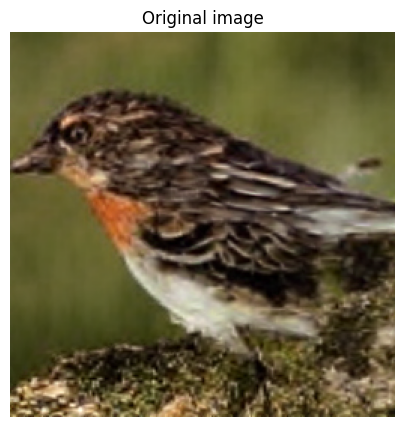

Optimizing image:   0%|          | 0/10000 [00:00<?, ?it/s]/home/myid/ty45972/miniconda3/envs/VQGAN/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 0, Loss: -1.3614636659622192
Pretrained model - Original label logit: 13.12799072265625, Target label logit: 5.875850677490234


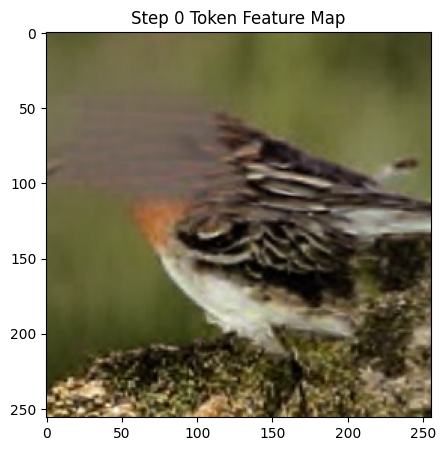

Optimizing image:  10%|▉         | 997/10000 [00:14<02:12, 68.19it/s]

Step 1000, Loss: -23.43231964111328
Pretrained model - Original label logit: 8.636019706726074, Target label logit: 7.3550944328308105


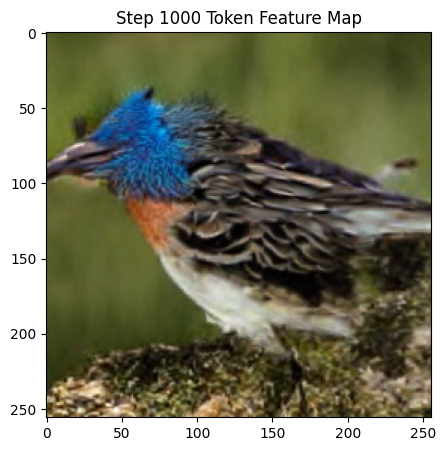

Optimizing image:  20%|█▉        | 1995/10000 [00:29<01:58, 67.72it/s]

Step 2000, Loss: -23.89189338684082
Pretrained model - Original label logit: 8.396086692810059, Target label logit: 6.842901706695557


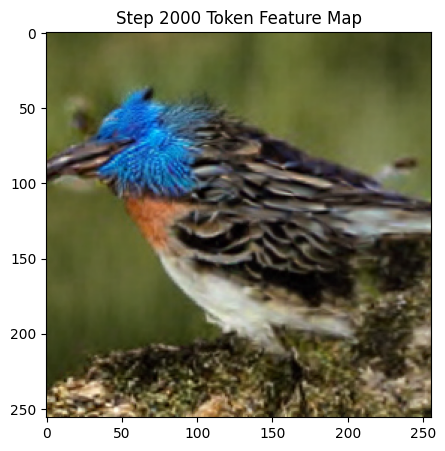

Optimizing image:  30%|██▉       | 2995/10000 [00:44<01:43, 67.79it/s]

Step 3000, Loss: -23.588985443115234
Pretrained model - Original label logit: 8.739487648010254, Target label logit: 6.806763172149658


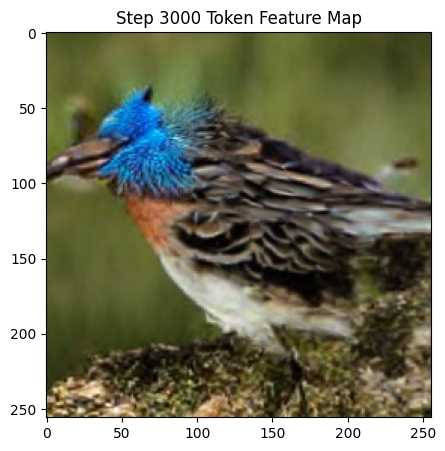

Optimizing image:  40%|███▉      | 3999/10000 [00:59<01:28, 67.74it/s]

Step 4000, Loss: -23.234712600708008
Pretrained model - Original label logit: 8.577394485473633, Target label logit: 6.713725566864014


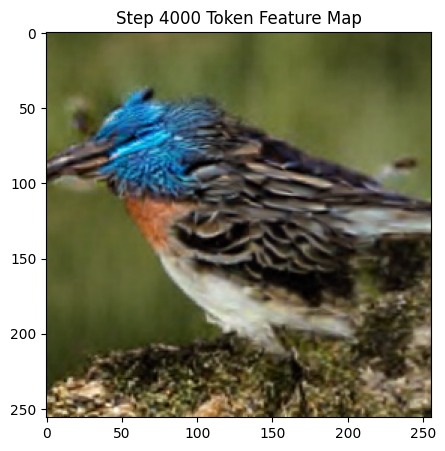

Optimizing image:  50%|████▉     | 4997/10000 [01:14<01:13, 67.73it/s]

Step 5000, Loss: -23.269939422607422
Pretrained model - Original label logit: 9.283195495605469, Target label logit: 8.290674209594727


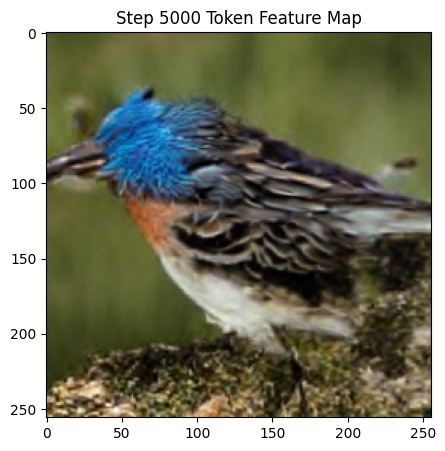

Optimizing image:  60%|█████▉    | 5998/10000 [01:29<00:58, 67.89it/s]

Step 6000, Loss: -23.954914093017578
Pretrained model - Original label logit: 9.078701972961426, Target label logit: 7.50775671005249


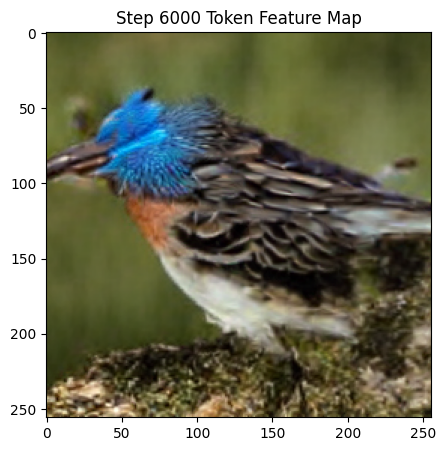

Optimizing image:  70%|██████▉   | 6999/10000 [01:44<00:44, 67.77it/s]

Step 7000, Loss: -23.6038761138916
Pretrained model - Original label logit: 8.43354320526123, Target label logit: 7.576074600219727


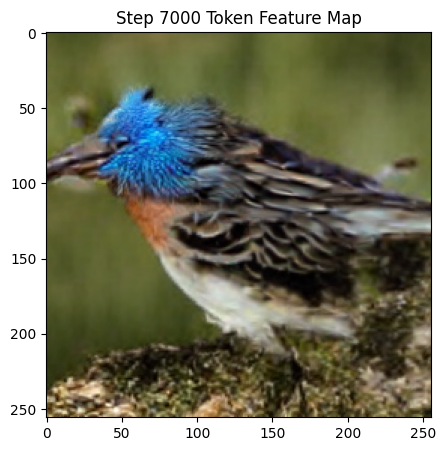

Optimizing image:  80%|███████▉  | 7997/10000 [01:59<00:29, 67.28it/s]

Step 8000, Loss: -23.516677856445312
Pretrained model - Original label logit: 9.831280708312988, Target label logit: 8.45193862915039


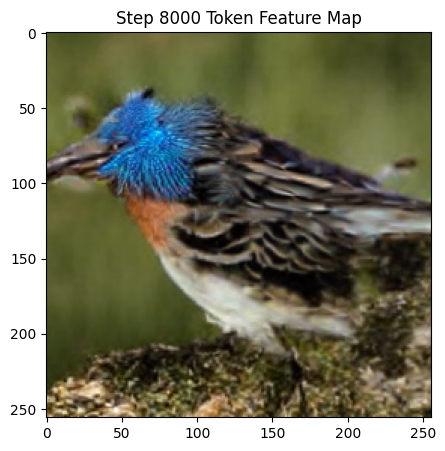

Optimizing image:  90%|████████▉ | 8995/10000 [02:14<00:15, 65.24it/s]

Step 9000, Loss: -23.947528839111328
Pretrained model - Original label logit: 9.486998558044434, Target label logit: 8.540704727172852


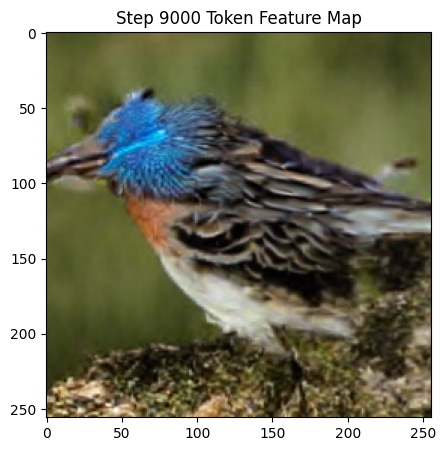

Optimizing image: 100%|█████████▉| 9999/10000 [02:29<00:00, 65.02it/s]

Step 9999, Loss: -23.588581085205078
Pretrained model - Original label logit: 10.504129409790039, Target label logit: 9.057571411132812


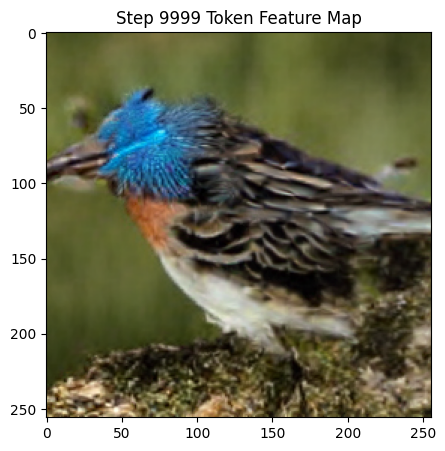

Optimizing image: 100%|██████████| 10000/10000 [02:30<00:00, 66.57it/s]

Positions where optimized tokens differ from initial tokens:
[33, 34, 35, 36, 37, 38, 49, 50, 51, 52, 53, 54, 65, 66, 67, 68, 69, 70, 81, 82, 83, 84, 85, 86, 97, 98, 99, 100, 101, 102]


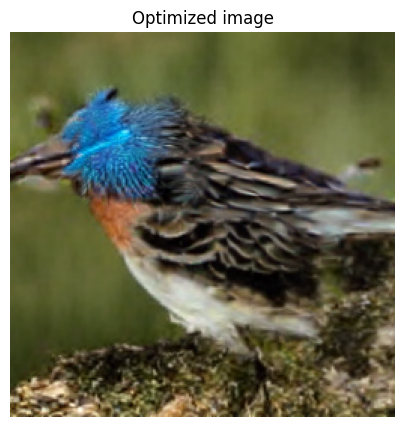

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import sys
import csv
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision

# 添加必要的路径
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(parent_directory)
from model import ClassificationNet1, ClassificationNet2, ClassificationNet3

parent_directory = os.path.abspath(os.path.join(current_directory, '../..'))
sys.path.append(parent_directory)

from omegaconf import OmegaConf
from main import instantiate_from_config
from einops import rearrange
from taming.models.new_vqgan import VQModel

# 设置参数
model_number = 1
gpu = 0
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')

def rescale(x):
    return (x + 1.) / 2.

def chw_to_pillow(x):
    return Image.fromarray((255*rescale(x.detach().cpu().numpy().transpose(1,2,0))).clip(0,255).astype(np.uint8))

def load_classification_model(model_choice, model_path, device):
    num_classes = 1000
    if model_choice == 1:
        model = ClassificationNet1(num_classes)
    elif model_choice == 2:
        model = ClassificationNet2(num_classes)
    elif model_choice == 3:
        model = ClassificationNet3(num_classes)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def load_pretrained_model(model_name, device):
    if model_name == 'resnet50':
        model = torchvision.models.resnet50(pretrained=True)
    elif model_name == 'vit_b_16':
        model = torchvision.models.vit_b_16(pretrained=True)
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    model.to(device)
    model.eval()
    return model

def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return preprocess(image).unsqueeze(0)

def load_model(config_path, checkpoint_path, device=None, eval_mode=True):
    config = OmegaConf.load(config_path)
    model = instantiate_from_config(config.model)
    
    if checkpoint_path and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location="cpu")
        if "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"])
        else:
            raise ValueError("Checkpoint does not contain state_dict.")
    else:
        raise ValueError(f"Checkpoint file {checkpoint_path} not found.")
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    
    if eval_mode:
        model.eval()
    
    return model

def decode_input_embedding(input_embedding, VQ_model):
    codebook = VQ_model.quantize.embedding

    z = rearrange(input_embedding, 'b c h w -> b h w c').contiguous()
    z_flattened = z.view(-1, 256)

    d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
        torch.sum(codebook.weight**2, dim=1) - 2 * \
        torch.einsum('bd,dn->bn', z_flattened, rearrange(codebook.weight, 'n d -> d n'))

    min_encoding_indices = torch.argmin(d, dim=1)

    z_q = codebook(min_encoding_indices).view(z.shape)

    z_q = rearrange(z_q, 'b h w c -> b c h w').contiguous()
    token_feature_map = VQ_model.decode(z_q)
    return z_q, min_encoding_indices, token_feature_map

def create_mask(shape, top_left, bottom_right):
    mask = torch.zeros(shape)
    for i in range(top_left[0], bottom_right[0]+1):
        for j in range(top_left[1], bottom_right[1]+1):
            index = i * 16 + j
            mask[index, :] = 1
    return mask

def sample_gumbel(shape, eps=1e-20, device='cpu'):
    U = torch.rand(shape, device=device)
    return -torch.log(-(torch.log(U + eps)) + eps)

def gumbel_softmax(logits, temperature, device='cpu', hard=True):
    gumbel_noise = sample_gumbel(logits.size(), device=device)
    y = logits + gumbel_noise
    y = torch.softmax(y / temperature, dim=-1)
    
    if hard:
        shape = y.size()
        _, max_idx = y.max(dim=-1, keepdim=True)  # 获取每行最大值对应的索引
        # print(f"max id is {max_idx}")
        y_hard = torch.zeros_like(y).scatter_(-1, max_idx, 1.0)  # 将最大索引位置置为1，其余位置为0
        y = (y_hard - y).detach() + y  # 通过Straight-Through技巧保留梯度
    return y, max_idx.squeeze(-1)  # 返回选择的one-hot矩阵和索引

def generate_max_activation_image(model, target_label, device, P, mask, codebook, VQ_model, num_steps=10000, lr=0.1, reg=0, pretrained_model=None, initial_label=None, temperature=1.0):
    P = P.to(device)
    P.requires_grad_(True)
    mask = mask.to(device)

    optimizer = torch.optim.Adam([P], lr=lr)
    
    for step in tqdm(range(num_steps), desc="Optimizing image"):
        optimizer.zero_grad()
        
        # 使用 Gumbel-Softmax 来选择 token
        selected_tokens, token_indices = gumbel_softmax(P, temperature, device=device, hard=True)
        
        # 从 codebook 中选择 token
        selected_embedding = torch.matmul(selected_tokens, codebook)
        selected_embedding = rearrange(selected_embedding, '(h w) d -> 1 d h w', h=16, w=16)
        
        output = model(selected_embedding)
        loss = -output[0, target_label] + reg * torch.mean(selected_embedding ** 2)
        
        loss.backward()
        
        # 只允许 mask 区域的梯度传播
        P.grad *= mask
        
        optimizer.step()
        
        if step % 1000 == 0 or step == num_steps - 1:
            print(f"Step {step}, Loss: {loss.item()}")
            _, _, token_feature_map = decode_input_embedding(selected_embedding, VQ_model)
            token_feature_map_img = chw_to_pillow(token_feature_map[0])
            
            if pretrained_model:
                preprocessed_img = preprocess_image(token_feature_map_img).to(device)
                with torch.no_grad():
                    pretrained_output = pretrained_model(preprocessed_img)
                original_logit = pretrained_output[0, initial_label].item()
                target_logit = pretrained_output[0, target_label].item()
                print(f"Pretrained model - Original label logit: {original_logit}, Target label logit: {target_logit}")
            
            plt.figure(figsize=(5, 5))
            plt.imshow(token_feature_map_img)
            plt.title(f"Step {step} Token Feature Map")
            plt.show()

    return P, selected_embedding, token_indices

def main():
    # 加载分类模型
    classification_model_path = f"/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/checkpoints/generated_data/ClassificationNet{model_number}/best_model.pth"
    classification_model = load_classification_model(model_number, classification_model_path, device)
    
    # 加载预训练模型
    pretrained_model = load_pretrained_model('resnet50', device)
    
    # 定义优化区域
    top_left = (2, 1)
    bottom_right = (6, 6)
    mask = create_mask((256, 16384), top_left, bottom_right)

    # 加载VQGAN模型
    config_path = "/data/ty45972/taming-transformers/logs/2021-04-03T19-39-50_cin_transformer/configs/2021-04-03T19-39-50-project.yaml"
    checkpoint_path = "/data/ty45972/taming-transformers/logs/2021-04-03T19-39-50_cin_transformer/checkpoints/last.ckpt"
    model = load_model(config_path, checkpoint_path, device=device, eval_mode=True)
    VQ_model = model.first_stage_model

    # 读取CSV文件
    csv_path = "/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated_new/test_embeddings.csv"
    with open(csv_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # 跳过标题行
        files_to_process = []
        for row in reader:
            initial_label = int(row[1])
            if 10 <= initial_label <= 20:
                # target_label = 30 - initial_label  # 如果初始标签是10，目标是20；如果是11，目标是19，依此类推
                target_label = 14
                files_to_process.append((row[0], initial_label, target_label))

    # 读取PKL文件
    pkl_path = '/data2/ty45972_data2/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated_new/test_token_indices.pkl'
    with open(pkl_path, 'rb') as f:
        token_dict = pickle.load(f)

    for file_name, initial_label, target_label in files_to_process:
        print(f"Processing file: {file_name}")
        print(f"Initial label: {initial_label}, Target label: {target_label}")
        
        # 获取初始token序列
        initial_tokens = token_dict[file_name]
        print(f"initial tokens are {initial_tokens}")
        
        # 初始化P矩阵
        P = torch.full((256, 16384), -300.0)
        for i, token in enumerate(initial_tokens):
            P[i, token] = 300.0   
        
        print("Initial P matrix max indices:")
        print(P.argmax(dim=1))
        
        # 随机初始化需要优化的区域
        optimizable_rows = torch.where(mask.sum(dim=1) > 0)[0]
        print(f"Optimizable rows are: {optimizable_rows}")
        P[optimizable_rows] = torch.randn(len(optimizable_rows), 16384)

        # 加载原始图像
        original_image_file = f"/data/ty45972/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated_new/test/{file_name}"
        image_array = np.load(original_image_file)
        original_image_tensor = torch.tensor(image_array).unsqueeze(0).to(device)
        
        # 解码并显示原始图像
        _, _, original_images = decode_input_embedding(original_image_tensor, VQ_model)
        for original_image in original_images:
            image = chw_to_pillow(original_image)
            plt.figure(figsize=(5, 5))
            plt.imshow(image)
            plt.title("Original image")
            plt.axis("off")
            plt.show()

        # 优化图像
        optimized_P, optimized_image_embedding, token_indices = generate_max_activation_image(
            classification_model, target_label, device, P, mask, VQ_model.quantize.embedding.weight,
            VQ_model, pretrained_model=pretrained_model, initial_label=initial_label, temperature=1.0
        )
        optimized_token_indices = token_indices.cpu().numpy()

        # 找出不同的索引位置
        different_positions = [i for i in range(len(initial_tokens)) if initial_tokens[i] != optimized_token_indices[i]]

        print("Positions where optimized tokens differ from initial tokens:")
        print(different_positions)
        # 解码并显示优化后的图像
        _, _, optimized_images = decode_input_embedding(optimized_image_embedding, VQ_model)
        for optimized_image in optimized_images:
            image = chw_to_pillow(optimized_image)
            plt.figure(figsize=(5, 5))
            plt.imshow(image)
            plt.title("Optimized image")
            plt.axis("off")
            plt.show()
        break

if __name__ == "__main__":
    main()

In [ ]:
original_image_file = f"/data/ty45972/taming-transformers/codebook_explanation_classification/datasets/VQGAN_16384_generated/test/{file_name}"
image_array = np.load(original_image_file)